通过skl定义一个简单的数据集:

[[-0.41567118  1.33679442  0.28920253]
 [ 1.12293737  0.91540988 -1.04159626]
 [ 0.85952355  1.18287403 -1.39886765]
 ...
 [-0.79508578  1.24439084  0.40400142]
 [ 0.90355608  0.95029717 -0.21341399]
 [-0.86886123  0.37997536  1.61599883]]
<class 'numpy.ndarray'> (10000, 2)
Figure(640x480) [-0.04156712  0.11229374  0.08595235 ... -0.07950858  0.09035561
 -0.08688612] [ 0.02892025 -0.10415963 -0.13988676 ...  0.04040014 -0.0213414
  0.16159988]
tensor([[-0.0416,  0.0289],
        [ 0.1123, -0.1042],
        [ 0.0860, -0.1399],
        ...,
        [-0.0795,  0.0404],
        [ 0.0904, -0.0213],
        [-0.0869,  0.1616]])


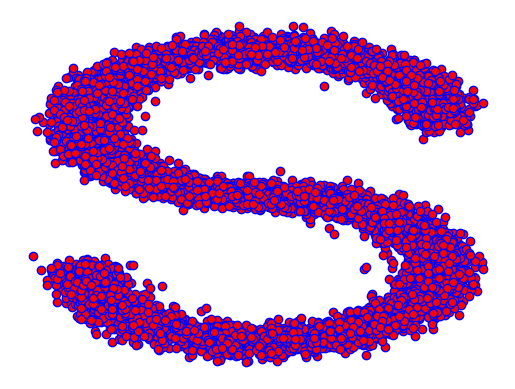

In [6]:
%matplotlib inline 
import matplotlib.pyplot as plt
import numpy as np
import torch
from sklearn.datasets import make_s_curve

s_curve,_ = make_s_curve(10000,noise = 0.1)
print(s_curve)
s_curve = s_curve[:,[0,2]]/10.0
s_curve.shape
print(type(s_curve),s_curve.shape)
# print(*s_curve)

data = s_curve.T #转置

fig,ax =plt.subplots();
print(fig,*data)
ax.scatter(*data,color='red',edgecolor = 'blue')
ax.axis('off')

dataset = torch.Tensor(s_curve).float()
print(dataset)

确定超参数的值

In [7]:
num_steps = 100

betas = torch.linspace(-6,6,num_steps)
# print(betas,0.5e-2)
betas = torch.sigmoid(betas)*(0.5e-2-1e-5)+1e-5
# print(betas)

alphas = 1-betas;
# print(alphas)
alphas_prod = torch.cumprod(alphas,0)# 连乘
# print("alpha_prod:",alphas_prod)

alphas_prod_p = torch.cat([torch.tensor([1]).float(),alphas_prod[:-1]],0) #t-1时刻的连乘结果
# print([torch.tensor([1]).float(),alphas_prod[:-1]],alphas_prod[:-1])
# print("alpha_prod_p:",alphas_prod_p)

alphas_bar_sqrt = torch.sqrt(alphas_prod)

one_minus_alphas_bar_sqrt = torch.sqrt(1-alphas_prod)
one_minus_alphas_bar_log = torch.log(1-alphas_prod)


确定扩散过程的任意时刻采样值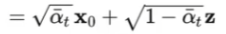
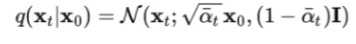


In [8]:
def q_x(x_0,t):
    nosie = torch.randn_like(x_0)
#     print(nosie)
    alphas_t = alphas_bar_sqrt[t]
    alphas_l_m_t = one_minus_alphas_bar_sqrt[t]
    return (alphas_t*x_0+alphas_l_m_t*nosie)

print(torch.randn_like(torch.tensor([1]).float()))

tensor([1.2230])


演示原始数据分布加噪100的结果

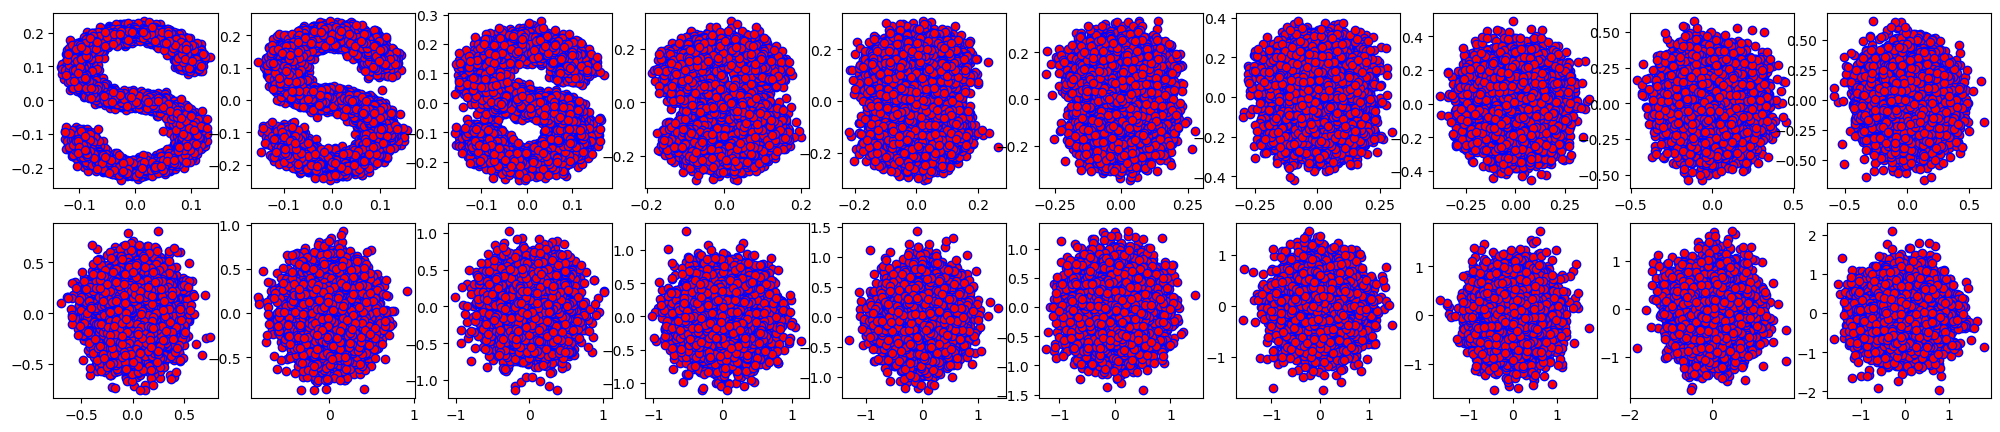

In [9]:
num_shows = 20
fig,axs = plt.subplots(2,10,figsize=(25,5))
plt.rc('text',color='blue')

for i in range(num_shows):
    j=i//10 #整除
    k=i%10
    q_i = q_x(dataset,torch.tensor([i*num_steps//num_shows])) #每隔5个时间绘制一幅图像
#     q_i = q_x(dataset,torch.tensor([i*num_steps//num_shows]))
    axs[j,k].scatter(q_i[:,0],q_i[:,1],color='red',edgecolor='blue')
    


编写逆扩散过程高斯分布模型

In [10]:
import torch
import torch.nn as nn

class MLPDiffusion(nn.Module):
    
    def __init_(self,n_steps,num_units = 128):
        super(MLPDiffusion,self).__init_()
        
        self.linears = nn.ModuleList([
            nn.Linear(2,num_units),
            nn.ReLU(),
            nn.Linear(num_units,num_units),
            nn.ReLU(),
            nn.Linear(num_units,num_units),
            nn.ReLU(),
            nn.Linear(num_units,2),
        ])
        slef.step_embeddings =nn.ModuleList([
            
            nn.Embedding(n_steps,num_units),
            nn.Embedding(n_steps,num_units),
            nn.Embedding(n_steps,num_units),
        ])
    
    def forward(self,x,t):
        
        for idx,embedding_layer in enumerate(self.step_embeddings):
            t_embedding = embedding_layer(t)
            x = self.linears[2*idx](x)
            x+=t_embedding
            x=self.linears[2*idx+1](x)
        x=self.linears[-1](x)
        
        return x

误差函数的编写：

In [ ]:
def diffusion_loss_fn(model,x_0,alphas_bar_sqrt,one_minus_alphas_bar_sqrt,n_steps):
    batch_size = x_0.shape[0]
    
    t = torch.randint(0,n_steps,size=(batch_size//2,))
    t = torch.cat([t,n_steps-1-t],dim=0)
    t = t.unsqueeze(-1)